# Density profile fit

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import h5py
from scipy.optimize import minimize
from density_fit_utils import *
import matplotlib

In [2]:
DATA_PATH = "../data/TangoSIDM/"

IDs = {
    "SigmaConstant00": "CDM",
    "SigmaConstant01": "SigmaConstant01",
    "SigmaConstant10": "SigmaConstant10",
    "SigmaVelDep20Anisotropic": "SigmaVel20",
    "SigmaVelDep60Anisotropic": "SigmaVel60", 
    "SigmaVelDep100Anisotropic": "SigmaVel100",
}

Choose halos. The data below comes from matching halos between boxes. 

In [3]:
idx = 7 

def select_halo(id): 

    halo = None
    
    if id == "SigmaConstant00":
        halo = [266825, 267106, 266829, 266826, 266827, 
                    266830, 266835, 266832, 266839, 266838, 
                    266831, 266836, 266837, 267107, 266840, 266842]
        
    if id == "SigmaConstant01":
        halo = [265554, 265803, 265557, 265555, 265558, 
                    265560, 265563, 265562, 265567, 265566, 
                    265561, 265564, 265565, 265559, 
                    265568, 265570]
        
    if id == "SigmaConstant10":
        halo = [257892, 258114, 257896, 257894, 257893,
                    257897, 257899, 258115, 257903, 257902, 
                    257895, 257901, 257900, 257904, 257905, 257895]
        
    if id == "SigmaVelDep20Anisotropic":
        halo = [265518, 265785, 265522, 265520, 265519, 
                    265523, 265527, 265524, 265531, 265530, 
                    265525, 265528, 265521, 265786, 
                    265532, 265534]
        
    if id == "SigmaVelDep60Anisotropic":
        halo = [263801, 264064, 263805, 263803, 263802, 
                    263806, 263810, 264065, 263813, 263812, 
                    263808, 263809, 263811, 263807,
                    263814, 263815]
        
    if id == "SigmaVelDep100Anisotropic":
        halo = [261828, 262076, 261832, 261830, 261829, 
                    261833, 261837,  262077, 261840, 261839, 
                    261835, 261836, 261838, 261834, 
                    261841, 261842]
        
    return halo[idx]

### Fitting routine

In [4]:
sampler_iso, r0_iso, rho0_iso = [], [], []
sampler_nfw, r0_nfw, rho0_nfw = [], [], []

for i, (id, id_name) in enumerate(IDs.items()):
    file = h5py.File(DATA_PATH+f"{id}.hdf5", "r")

    halo = select_halo(id)    
    data_subhalo = file[f'{halo}']['halo_data']
    centers = data_subhalo['centered_radial_bins'][8:]
    density = data_subhalo['dm_density'][8:]
    
    x, y = centers, density
    nozero = y > 0
    x = x[nozero]
    y = y[nozero]

    # Let's define inner region as everything within 25 kpc
    inner = np.where((x <= 5) & (x >= 0.5))[0]

    x = x[inner]
    y = np.log10(y[inner])
    yerr = np.ones(len(y)) * 0.1

    np.random.seed(42)
    nll = lambda *args: -log_likelihood_nfw(*args)
    initial = np.array([1, 7])
    soln = minimize(nll, initial, args=(x, y, yerr))
    r0, rho0 = soln.x
    print('=======')
    print(r0, rho0)

    a, b, c = run_mcmc_nfw(x, y, yerr, soln)
    sampler_nfw.append(a)
    r0_nfw.append(b)
    rho0_nfw.append(c)
    
    np.random.seed(42)
    nll = lambda *args: -log_likelihood_iso(*args)
    initial = np.array([1, 7])
    soln = minimize(nll, initial, args=(x, y, yerr))
    r0, rho0 = soln.x
    print('=======')
    print(r0, rho0)

    a, b, c = run_mcmc_iso(x, y, yerr, soln)
    sampler_iso.append(a)
    r0_iso.append(b)
    rho0_iso.append(c)
    
    file.close()

4.805537441725376 6.459290965067583


100%|██████████| 5000/5000 [00:19<00:00, 258.91it/s]


Multiprocessing took 0.4 minutes
Mean autocorrelation time: 59.706 steps
0.5885788084791207 7.1597604417168


100%|██████████| 5000/5000 [01:31<00:00, 54.85it/s]


Multiprocessing took 1.6 minutes
Mean autocorrelation time: 31.245 steps
5.0959758415130585 6.496147113226815


100%|██████████| 5000/5000 [00:18<00:00, 277.01it/s]


Multiprocessing took 0.3 minutes
Mean autocorrelation time: 52.147 steps
0.613801972433569 7.208969254438565


100%|██████████| 5000/5000 [01:30<00:00, 55.41it/s]


Multiprocessing took 1.5 minutes
Mean autocorrelation time: 35.008 steps
1421.3389301235004 4.110568952733178


  0%|          | 0/5000 [00:00<?, ?it/s]/Users/n.anaumonteluva.nl/opt/anaconda3/envs/tangoconda/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 5000/5000 [00:11<00:00, 423.85it/s]
/Users/n.anaumonteluva.nl/opt/anaconda3/envs/tangoconda/lib/python3.9/site-packages/emcee/autocorr.py:38: RuntimeWarning: invalid value encountered in true_divide
  acf /= acf[0]


Multiprocessing took 0.2 minutes
Mean autocorrelation time: nan steps
1.0077357194239653 7.2960524738976655


100%|██████████| 5000/5000 [01:24<00:00, 59.06it/s]


Multiprocessing took 1.4 minutes
Mean autocorrelation time: 32.720 steps
5.906580138754404 6.370694316734031


100%|██████████| 5000/5000 [00:18<00:00, 263.87it/s]


Multiprocessing took 0.4 minutes
Mean autocorrelation time: 50.883 steps
0.633920366693153 7.160639514938389


100%|██████████| 5000/5000 [01:20<00:00, 62.44it/s]


Multiprocessing took 1.4 minutes
Mean autocorrelation time: 33.449 steps
8.892124197692212 6.59876486472855


/Users/n.anaumonteluva.nl/VSCode/TangoSIDM/TangoSIDM_satellites/examples/density_fit_utils.py:134: RuntimeWarning: invalid value encountered in log10
  yrange = np.log10(sol)
100%|██████████| 5000/5000 [00:16<00:00, 295.75it/s]


Multiprocessing took 0.3 minutes
Mean autocorrelation time: 43.344 steps
0.7113205191517918 7.57327922911643


100%|██████████| 5000/5000 [01:28<00:00, 56.22it/s]


Multiprocessing took 1.5 minutes
Mean autocorrelation time: 31.944 steps
22.771069973503096 6.052252097198443


  0%|          | 0/5000 [00:00<?, ?it/s]/Users/n.anaumonteluva.nl/opt/anaconda3/envs/tangoconda/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 5000/5000 [00:10<00:00, 476.91it/s]
/Users/n.anaumonteluva.nl/opt/anaconda3/envs/tangoconda/lib/python3.9/site-packages/emcee/autocorr.py:38: RuntimeWarning: invalid value encountered in true_divide
  acf /= acf[0]


Multiprocessing took 0.2 minutes
Mean autocorrelation time: nan steps
0.8465123048520404 7.4465163654674065


100%|██████████| 5000/5000 [01:28<00:00, 56.65it/s]

Multiprocessing took 1.5 minutes
Mean autocorrelation time: 31.696 steps


### Plotting routine

r0 5.445820380495407 1.710407475287289
rho0 6.374096739232941 0.20707993568118382
r0 1.028534290280203 0.12415045665398898
rho0 7.287309283413043 0.057574336141649855
r0 0.8612585269144661 0.0986269519462678
rho0 7.4391205249619095 0.06380775857188745


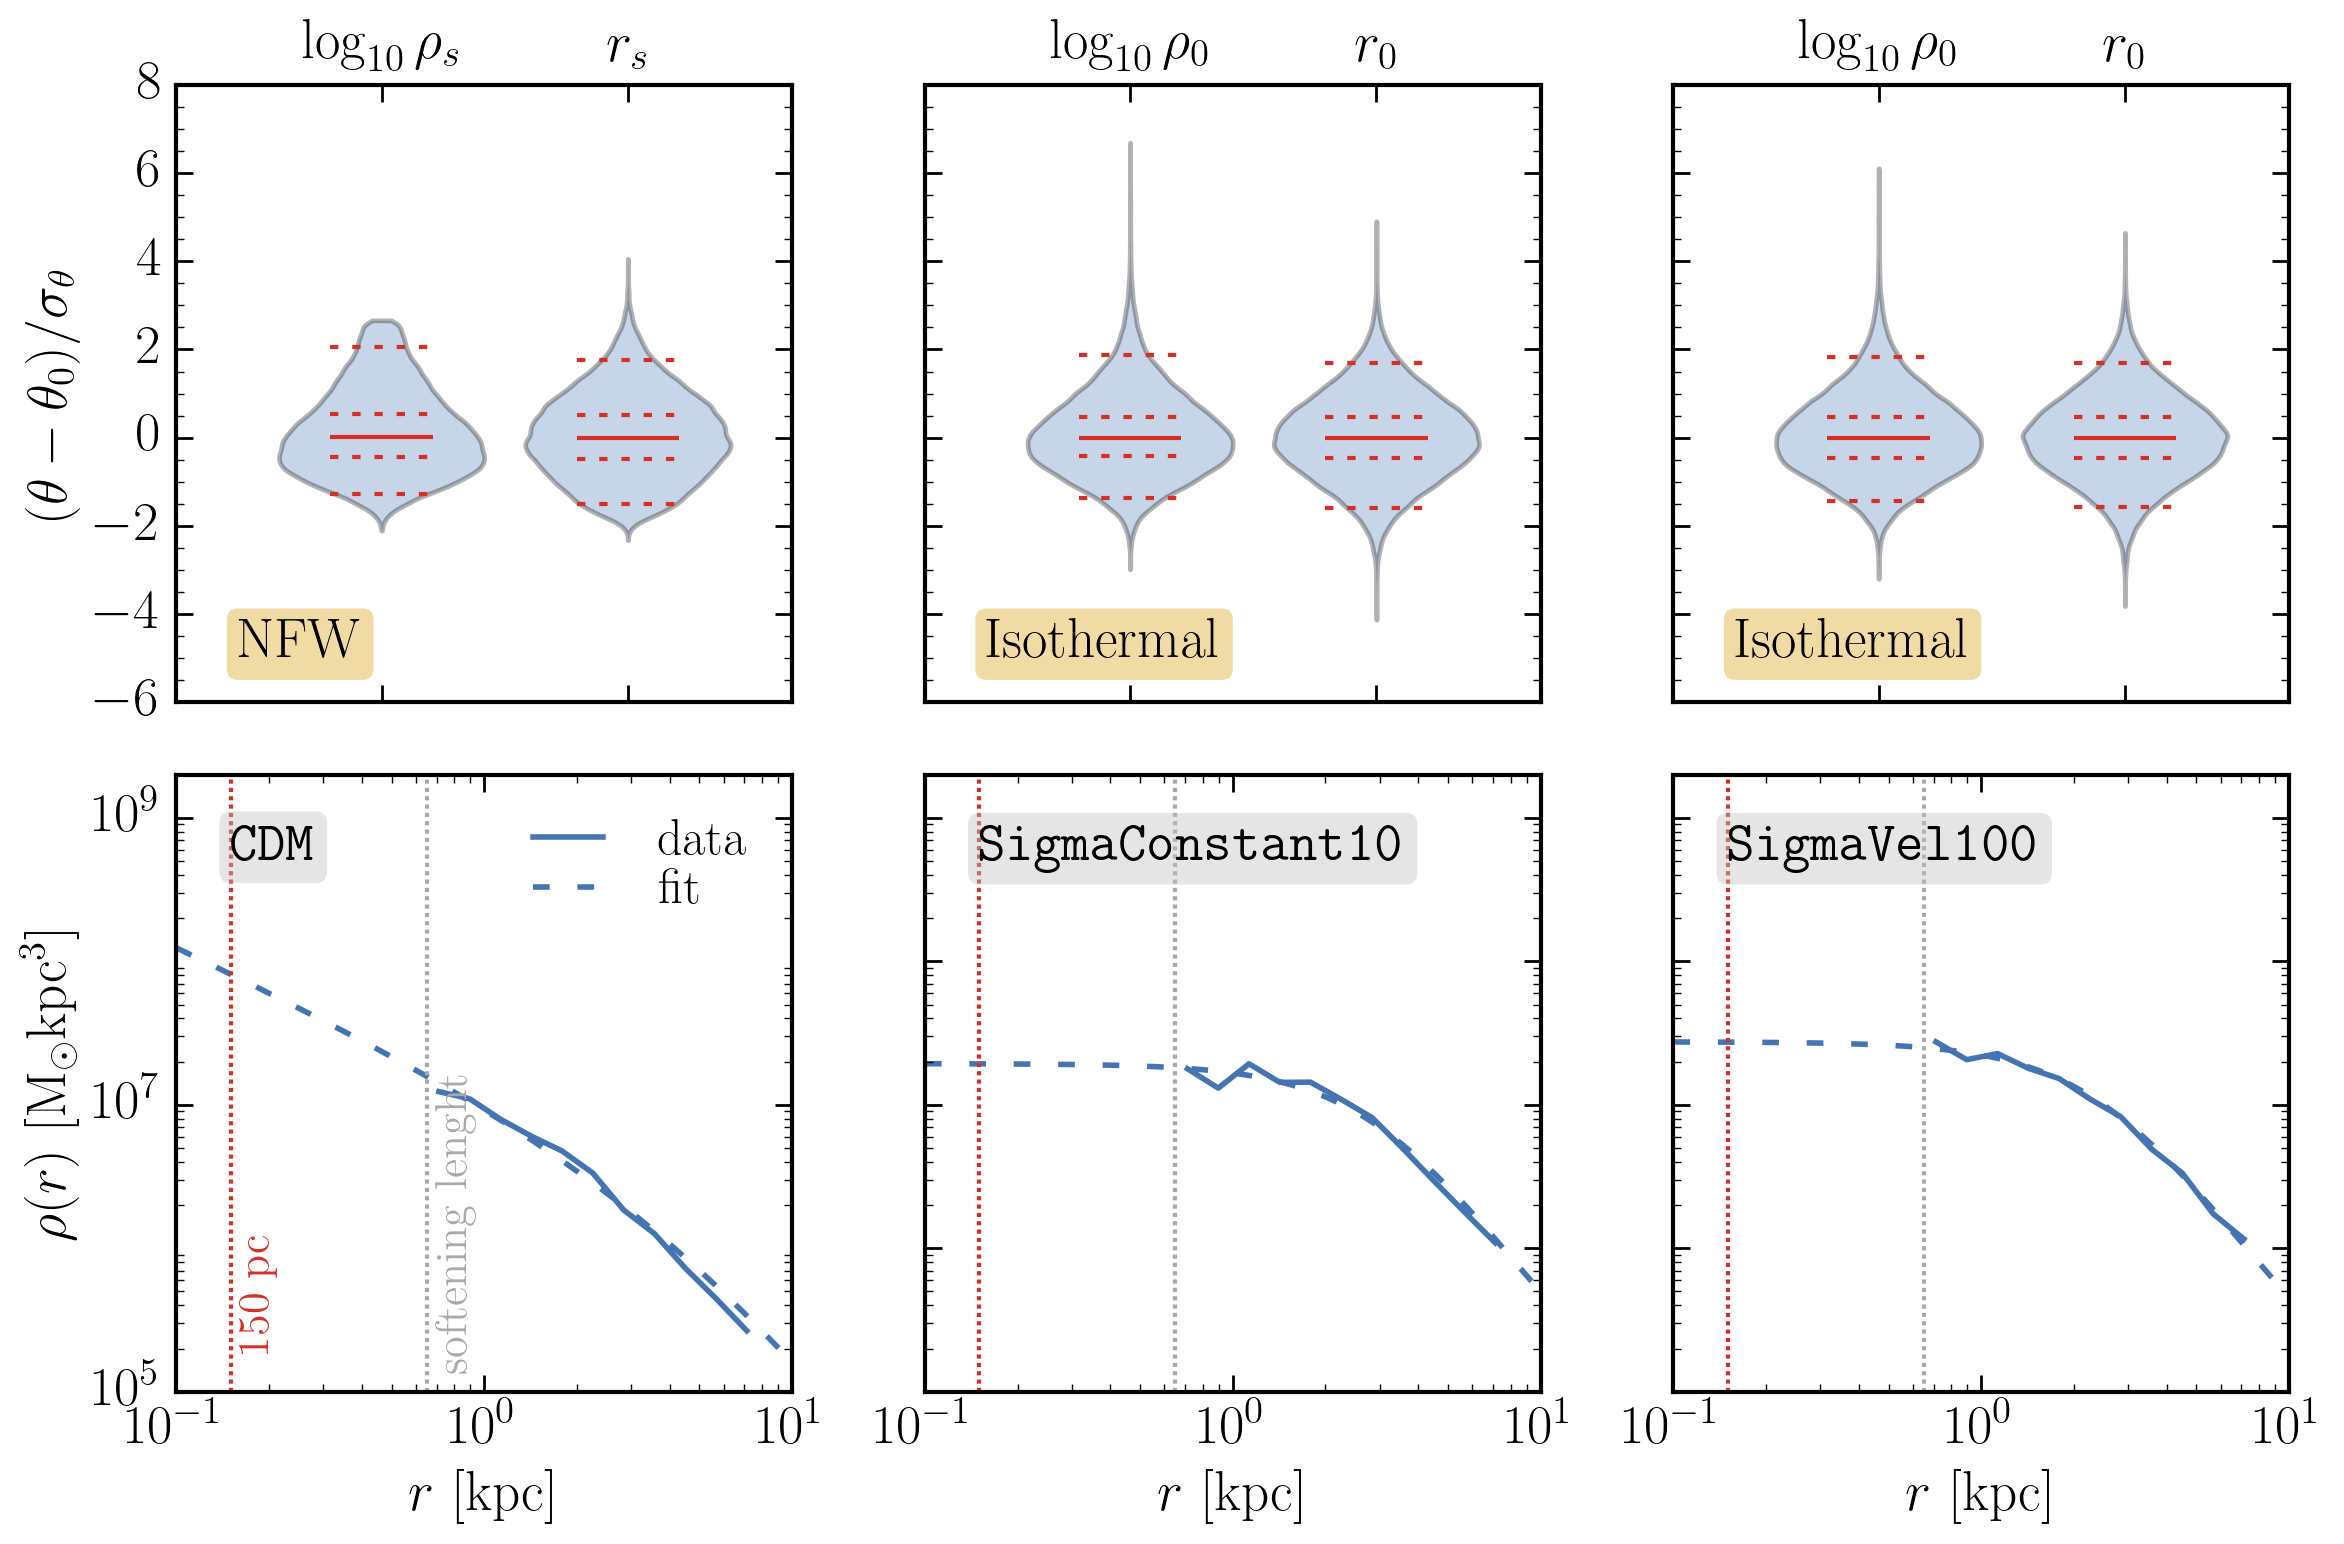

In [5]:
mycmap = matplotlib.cm.RdYlBu
myred = mycmap(0.1)
myblue =  mycmap(0.9)

plt.style.use("pltstyle.mplstyle")

fig, axs = plt.subplots(2, 3, figsize=(12,8), dpi=200, facecolor='white') 
axs1, axs0 = axs

j = 0
for i, (id, id_name) in enumerate(IDs.items()):
    if id_name in ["CDM", "SigmaConstant10", "SigmaVel100"]:
        file = h5py.File(DATA_PATH+f"{id}.hdf5", "r")
        halo = select_halo(id)

        data_subhalo = file[f'{halo}']['halo_data']
        centered_radial_bins = data_subhalo["centered_radial_bins"][8:19]
        dm_density = data_subhalo["dm_density"][8:19]

        xrange = np.arange(-1, 1, 0.01)
        xrange = 10**xrange

        if id_name == "CDM": # use NFW fit
            sampler, r0, rho0 = sampler_nfw[i], r0_nfw[i], rho0_nfw[i]
            model = fit_nfw_model(xrange, r0, rho0)
            tau = sampler.get_autocorr_time()
            burnin = int(2 * np.max(tau))
            thin = int(0.5 * np.min(tau))
            samples = sampler.get_chain(discard=burnin, flat=True, thin=1)
            label = [r"$\log_{10} \rho_s$", r"$r_s$"]
            fit = 'NFW'
        else: # use Isothermal fit
            sampler, r0, rho0 = sampler_iso[i], r0_iso[i], rho0_iso[i]
            model = fit_isothermal_model(xrange, r0, rho0)
            tau = sampler.get_autocorr_time()
            burnin = int(2 * np.max(tau))
            thin = int(0.5 * np.min(tau))
            samples = sampler.get_chain(discard=burnin, flat=True, thin=1)
            label = [r"$\log_{10} \rho_0 $", r"$r_0$"]
            fit = 'Isothermal'

        # Plot density
        print('r0', r0, samples[:, 0].std())
        print('rho0', rho0, samples[:, 1].std())
        samples_r0 = (samples[:, 0] - r0) / samples[:, 0].std()
        samples_rho0 = (samples[:, 1] - rho0) / samples[:, 1].std()
        data = [samples_r0, samples_rho0]

        parts = axs1[j].violinplot(data, positions=[1, 1.6], showmedians=True, showextrema=False, quantiles=[[0.05, 0.32, 0.68, 0.95], [0.05, 0.32, 0.68, 0.95]])
        parts['cmedians'].set_color(myred)
        parts['cquantiles'].set_color(myred)
        parts['cquantiles'].set_linestyle('--')

        for pb in parts['bodies']:
            pb.set_facecolor(myblue)
            pb.set_alpha(0.3)

        axs1[j].set_ylim(-6, 8)
        axs1[j].xaxis.tick_top()
        axs1[j].xaxis.set_ticks_position('both')
        axs1[j].set_xlim(0.5,2.)
        axs1[j].set_xticks([1, 1.6], labels=label)
        axs1[j].xaxis.set_tick_params(which='minor', bottom=False, top=False)
        
        # Plot fit
        p = axs0[j].loglog(centered_radial_bins, dm_density, c=myblue, lw=2) 
        axs0[j].loglog(xrange, 10**model, ls='--', c=myblue, lw=2) #, c=p[0].get_color())

        axs0[j].set_xscale("log")
        axs0[j].set_yscale("log")
        axs0[j].set_ylim(1e5, 2e9)
        axs0[j].set_xlabel(r"$r \ [\mathrm{kpc}]$")

        # vertical lines
        axs0[j].axvline(0.65, c='darkgray', ls=(0, (1, 1)))
        axs0[j].axvline(0.15, c=myred, ls=(0, (1, 1)))

        if i!=0:
            axs0[j].set_yticklabels([])
            axs1[j].set_yticklabels([])

        if i==0:
            axs0[j].plot([],[], lw=2, ls='-', color=myblue, label=r'$\mathrm{data}$')
            axs0[j].plot([],[], lw=2, ls='--', color=myblue, label=r'$\mathrm{fit}$')
            axs0[j].legend(labelspacing=0.1, fontsize=18, loc='upper right', markerscale=2.8)

        axs0[j].text(0.15,5e8, fr'$\texttt{{{id_name}}}$', color='black', fontsize=20, 
                 bbox=dict(facecolor='silver', edgecolor='none', alpha=0.4, boxstyle='round, pad=0.2'))
        
        axs1[j].text(0.65, -5, fr'$\mathrm{{{fit}}}$', color='black', fontsize=20, 
                 bbox=dict(facecolor='goldenrod', edgecolor='none', alpha=0.4, boxstyle='round, pad=0.2'))

        file.close()
        j+=1

axs1[0].set_ylabel(r"$(\theta - \theta_0)/\sigma_{\theta}$")
axs0[0].text(0.7, 1.5e6, "$\mathrm{softening\ lenght}$", c='darkgray', rotation=90, verticalalignment='center')
axs0[0].text(0.158, 5e5, r"$150 \mathrm{\ pc}$", c=myred, rotation=90, verticalalignment='center')
axs0[0].set_yticks([1e5, 1e7, 1e9])
axs0[0].set_ylabel(r"$\rho(r) \ [\mathrm{M_\odot kpc^3}]$")
plt.tight_layout()
fig.savefig("./figures/mcmc_fit_base.png", dpi=300, transparent=True)